# Set environment (Only for usage with Google Colab)

In [ ]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [ ]:
# !git clone https://github.com/gilbertolem/ProgGen

In [ ]:
# from os import chdir, getcwd
# chdir("ProgGen")
# from sys import path
# path.append(getcwd())

# Import Libraries

In [1]:
import torch
import utils.data_tools as data_tools
from utils.nets import ProgGenRNN, WeightedLoss
from pickle import load
import matplotlib.pyplot as plt
from numpy import argmin

xml_directory = "XML_Tunes/"
torch.manual_seed(999)
use_gpu = torch.cuda.is_available()
print("GPU available: {}".format(use_gpu))

GPU available: False


# Load Vocabulary

In [2]:
words_text2num = load(open("maps/words_text2num.txt",'rb'))
vocab_size = len(words_text2num)

# Create training data

In [3]:
filter_names = ['Charlie Parker']
filter_fracs = [1.0]

filters = {'names':filter_names, 'frac':filter_fracs}
Train, Val = data_tools.musicxml2tensor(xml_directory, words_text2num, filters=filters)
train_data = data_tools.TuneData(Train)
val_data = data_tools.TuneData(Val)


CREATING TENSORS FROM MUSICXML FILES...
	297 tunes successfully loaded for training.
	75 tunes successfully loaded for validation.


# Construct Neural Net

In [4]:
# Embedding type
embed_size = 100 

# Net Type
rnn_type = 'lstm'
bidirectional = True

# RNN parameters
num_layers = 1
hidden_rnn = 100
dropout_rnn = 0.0

# FC layers parameters
hidden_fc = 0
dropout_fc = 0.0

# Create model and loss function
model = ProgGenRNN(vocab_size, embed_size, rnn_type, bidirectional, 
                   hidden_rnn, num_layers, dropout_rnn, 
                   hidden_fc, dropout_fc)
loss_fn = WeightedLoss()

# Define loader
sampler = torch.utils.data.RandomSampler(train_data)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3000 if use_gpu else 512, sampler=sampler, num_workers=1 if use_gpu else 4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=3000 if use_gpu else 512, num_workers=1 if use_gpu else 4)

if use_gpu:
    model = model.cuda()
    loss_fn = loss_fn.cuda()

# Define loss function and optimizer

In [5]:
lr = 1e-2
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Train net


--------------------------------------------------------------------
TRAINING MODEL... 

   Epoch | Training Loss | Val. Loss
       0 |          5.45 |      5.43
       1 |          3.86 |      3.58
       2 |          3.14 |      2.84
       3 |          3.08 |      2.76
       4 |          2.86 |      2.63
       5 |          2.65 |       2.5
       6 |          2.54 |      2.43
       7 |          2.45 |      2.36
       8 |          2.33 |      2.26
       9 |          2.21 |      2.15
      10 |           2.1 |      2.04
      11 |          2.01 |      1.96
      12 |          1.94 |      1.89
      13 |          1.89 |      1.84
      14 |          1.85 |      1.81
      15 |          1.81 |      1.79
      16 |          1.78 |      1.77
      17 |          1.76 |      1.75
      18 |          1.73 |      1.72
      19 |           1.7 |       1.7
      20 |          1.67 |      1.67
      21 |          1.65 |      1.64
      22 |          1.62 |      1.62
      23 |          1.

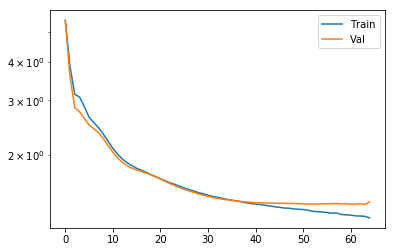

In [6]:
from utils.training import train
epochs = 500
losses = train(epochs, model, optim, train_loader, val_loader, loss_fn, use_gpu)

idx = argmin(losses[1])
print("Best Loss:\n\tTrain: {}\n\tVal: {}".format(losses[0][idx], losses[1][idx]))

plt.semilogy(losses[0], label='Train')
plt.semilogy(losses[1], label='Val')
plt.legend()
plt.show()

# Generate something

In [8]:
from utils.generating import generate_progression

model_name = "model"
initial_chord = "4C_m"
tune_len = 40
top = 10

prog = generate_progression(initial_chord, tune_len, top, model_name, verbose = False)
print("Generated Progression:\n")
print(prog)

Generated Progression:

Cm             |F7             |Bbmaj          |Bbmaj          |
Cm      F7     |Bbmaj          |Am7b5   D7alt  |Em      A7     |
Dmaj           |Dmaj           |Dm             |G7             |
C7             |Fmaj           |Bm7b5   E7alt  |D7     |
Emaj           |Emaj           |F#7            |F#7            |
B7             |B7             |E7             |A7             |
Dmaj           |C#m7b5  F#7alt |Bm             |Bm             |
E7             |Amaj           |Am      Abm    |Fm7b5   Bb7alt |
Ebm     Ab7alt |
